# Sentiment analysis of online reviews.

## a) Parse file

In [544]:
import numpy as np
from matplotlib import pylab as plt
import matplotlib.cm as cm
%matplotlib inline

In [545]:
sentence = []
label = []

In [546]:
def readFile(filePath, sentence, label):
    for line in open(filePath):
        tokens = line.strip().split("\t")
        sentence.append(tokens[0])
        label.append(tokens[1])

In [547]:
readFile("./data/amazon_cells_labelled.txt", sentence, label)

In [548]:
readFile("./data/imdb_labelled.txt", sentence, label)

In [549]:
readFile("./data/yelp_labelled.txt", sentence, label)

In [550]:
sentence = np.array(sentence)
label = np.array(label)

#### There are 500 positive and 500 negative sentences each set, so the labels are balanced according to README included with the data.

#### We process it by appending them to 2 np arrays. One for sentence and one for its label.

## b) Preprocessing Strategy

### b.1 Lowercase all words for ease of word matching

In [551]:
sentence = np.char.lower(sentence)

In [552]:
sentence[0]

'so there is no way for me to plug it in here in the us unless i go by a converter.'

### b.2 Lemmatization of all words helps cluster words with same meaning

### b.3 Strip the stopwords. Remove words like 'the', 'is', 'are' which have no value in our analysis

### b.3 Strip Punctuation. Punctuation again does not provide any value in matching. So remove it can possibly improve accuracy.

In [553]:
import re
# nltk.download() if not installed nltk
from nltk.corpus import stopwords  # Stopwords: ‘the’, ‘is’, ‘are’...
from nltk.stem.porter import * # Stem: gamer, gaming, game -> game
from nltk.tokenize import RegexpTokenizer # Regexp: set rule to just tokenize word

In [554]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')

In [555]:
for i in range(len(sentence)):
    words = []
    for word in tokenizer.tokenize(sentence[i]): # Remove punctuation
        if word not in stop_words: # Remove stopwords
            words.append(stemmer.stem(word)) # Stem word
        sentence[i] = " ".join(words)

In [556]:
sentence[0]

'way plug us unless go convert'

## c) Split training and testing set: use the first 400 instances for EACH label as the training set and the remaining 100 instances as testing set.

In [557]:
train_data, train_label = [],[]
test_data, test_label = [],[]

In [558]:
u_labels = np.unique(label) # unique labels
u_labels

array(['0', '1'],
      dtype='<U1')

In [559]:
for file in range(0,3):    
    label_count = [0] * len(u_labels) # array to count each label type
    for i in range(file*1000, file*1000 + 1000):
        for l in range(len(u_labels)):
            if label[i] == u_labels[l]:
                label_count[l] = label_count[l] + 1
                if label_count[l] <= 400:
                    train_data.append(sentence[i])
                    train_label.append(u_labels[l])
                else:
                    test_data.append(sentence[i])
                    test_label.append(u_labels[l])

In [560]:
train_data = np.array(train_data)
test_data = np.array(test_data)
train_label = np.array(train_label)
test_label = np.array(test_label)

In [561]:
len(train_data)

2400

In [562]:
len(test_data)

600

## d) Bag of Words Model

#### Dictionary of unique words from training set. We don't use testing set here because this is training step. If we use test data here, the model will overfit.

In [563]:
dict = {}
i = 0
for line in train_data:
    for word in line.split():
        if word not in dict:
            dict[word] = i
            i = i + 1

In [564]:
length = len(dict)
length

3500

#### Count occurence of word in each review

In [565]:
train_feature = []
test_feature = []

In [566]:
for line in train_data:
    freq = [0] * length
    for word in line.split():
        freq[dict[word]] += 1
    train_feature.append(freq)

In [567]:
for line in test_data:
    freq = [0] * length
    for word in line.split():
        if word in dict:
            freq[dict[word]] +=1
    test_feature.append(freq)

#### Present any 2 reviews in training set

In [568]:
train_feature = np.array(train_feature, dtype=float)

In [569]:
train_feature.size

8400000

In [570]:
train_feature[0]

array([ 1.,  1.,  1., ...,  0.,  0.,  0.])

In [571]:
train_data[1]

'good case excel valu'

In [572]:
train_feature[1]

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [573]:
test_feature = np.array(test_feature, dtype=float)

## e) Postprocessing Strategy

In [574]:
from sklearn import preprocessing

In [575]:
train_post_l2 = preprocessing.normalize(train_feature, norm='l2')

In [576]:
test_post_l2 = preprocessing.normalize(test_feature, norm='l2')

In [577]:
train_post_l1 = preprocessing.normalize(train_feature, norm='l1')

In [578]:
test_post_l1 = preprocessing.normalize(test_feature, norm='l1')

#### We employ both l1 and l2 norm since they are effective on sparse data. l2 pull its elements into sphere. l1 pulls its elements into a square shaped target. Either way, they all force the elements come closer together in term of similarity.

#### As we can see from the scores below, L2 does better than L1 in Logistic Regression.
#### But in Naive Bayes, L1 does better than L2.

## f) Sentiment Prediction

In [579]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import itertools #iterator for looping

In [580]:
def plot_confusion_matrix(test_label, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(test_label, y_pred)
    plt.figure()
    classes = {"0", "1"}
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent)
    plt.title(title)    
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    
    threshold = cm.max() / 2;

    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black")
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [581]:
def calculate_model(model, train_data, train_label, test_data, test_label, dictionary, title):
    # Caluclate Accuracy
    model.fit(train_data, train_label)
    score = model.score(test_data, test_label)
    print("Accuracy: {}".format(score))
    
    # Plot Confusion Matrix
    y_pred = model.predict(test_data)
    np.set_printoptions(precision=2)
    plot_confusion_matrix(test_label, y_pred, title=title)
    
    
    # What are the words that play the most important roles in deciding the sentiment of the reviews?
    if hasattr(model, 'coef_'):
        coeff = np.argsort(np.absolute(model.coef_))[0]
        significant = coeff[::-1][:20]
        print("Weights: ", significant)
        print("20 Significant Words:")
        for i in significant:
            for w in dictionary.keys():
                if dictionary[w] == i:
                    print(w)

### Logistic Regrssion Model

Regression Model with L1 norm
Accuracy: 0.775


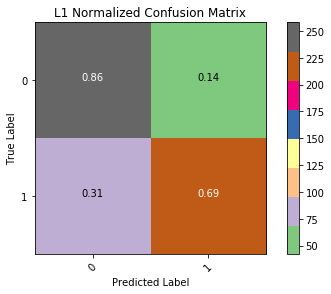

Weights:  [  10  223   95    8    6  170  113  161   40 2924  144  915  664  571  454
  190  708  173  505 1088]
20 Significant Words:
great
bad
love
excel
good
nice
best
poor
wast
delici
well
amaz
terribl
worst
fantast
disappoint
suck
price
awesom
aw


In [582]:
print("Regression Model with L1 norm")
calculate_model(LogisticRegression(), train_post_l1, train_label, test_post_l1, test_label, dict,title="L1 Normalized Confusion Matrix")

Regression Model with L2 norm
Accuracy: 0.8166666666666667


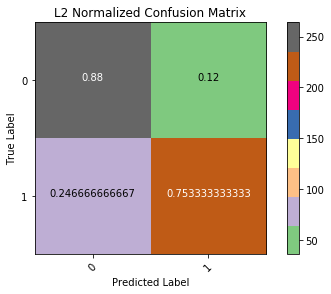

Weights:  [  10   95  223    8  170 2924  915  161    6  113  571  454  664  144   40
  505  279  708   65 1088]
20 Significant Words:
great
love
bad
excel
nice
delici
amaz
poor
good
best
worst
fantast
terribl
well
wast
awesom
beauti
suck
comfort
aw


In [583]:
print("Regression Model with L2 norm")
calculate_model(LogisticRegression(), train_post_l2, train_label, test_post_l2, test_label, dict,title="L2 Normalized Confusion Matrix")

### Naive Bayes Model

In [584]:
from sklearn.naive_bayes import GaussianNB

Naive Bayes Model with L1 norm
Accuracy: 0.7133333333333334


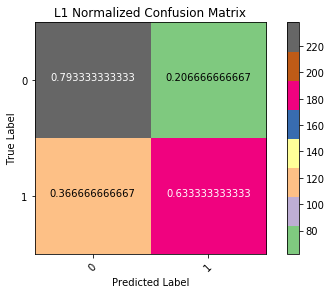

In [585]:
print("Naive Bayes Model with L1 norm")
calculate_model(GaussianNB(), train_post_l1, train_label, test_post_l1, test_label, dict,title="L1 Normalized Confusion Matrix")

Naive Bayes Model with L2 norm
Accuracy: 0.6966666666666667


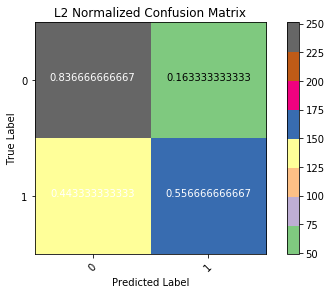

In [586]:
print("Naive Bayes Model with L2 norm")
calculate_model(GaussianNB(), train_post_l2, train_label, test_post_l2, test_label, dict,title="L2 Normalized Confusion Matrix")

## g) N-gram Model

### N-gram

In [587]:
def ngram(text,n):  
    model=[]  
    words = text.split()
    if len(words) <= n:
        return [text]
    for i in range(len(words) - n + 1):
        model.append(" ".join(words[i:i+n]))
    return model

### Index words

def make_ng_dict(n):
    nword_index = {}
    i = 0
    
    for line in train_data:
        for nw in ngram(line, n):
            if nw not in nword_index:
                nword_index[nw] = i;
                i = i + 1
    return nword_index

In [588]:
nword_index = make_ng_dict(2)

### Create Feature Vectors

In [589]:
def feature_ng(data, word_index, n):
    fea_v = []
    w_count = len(word_index)

    for line in data:
        freq = [0] * w_count
        for nw in ngram(line,n):
            if nw in nword_index:
                freq[nword_index[nw]] += 1
        fea_v.append(freq)
    return np.array(fea_v)
        

In [590]:
train_feature_ng = feature_ng(train_data, nword_index, 2)

In [591]:
test_feature_ng = feature_ng(test_data, nword_index, 2)

### Post Process. 

In [592]:
train_post_l1_ng = preprocessing.normalize(train_feature_ng, norm='l1')

In [593]:
test_post_l1_ng = preprocessing.normalize(test_feature_ng, norm='l1')

In [594]:
train_post_l2_ng = preprocessing.normalize(train_feature_ng, norm='l2')

In [595]:
test_post_l2_ng = preprocessing.normalize(test_feature_ng, norm='l2')

### Sentiment Prediction

#### Logistic Regression

Logistic Regression Model with L1 norm
Accuracy: 0.6433333333333333


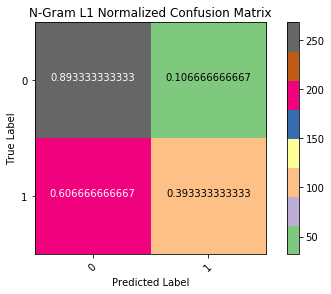

Weights:  [  71   63  622  783   37  243  516 3840 9321  368 4201 3110  975 7960 1121
  761  413  342 8186  968]
20 Significant Words:
advis
ear
factor
especi
must
parti
mail
sleek
pepper
earset
interest
oper
peachi
350
shift


In [596]:
print("Logistic Regression Model with L1 norm")
calculate_model(LogisticRegression(), train_post_l1_ng, train_label, test_post_l1_ng, test_label, dict,title="N-Gram L1 Normalized Confusion Matrix")

Regression Model with L2 norm
Accuracy: 0.645


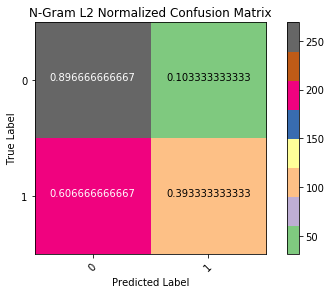

Weights:  [  71   63  622  413  783  243   37  516 3840 9321  368  975 8186 4958 1121
 7960 4201 2100 8424 3110]
20 Significant Words:
advis
ear
factor
peachi
especi
parti
must
mail
sleek
earset
interest
throwback
pepper


In [597]:
print("Regression Model with L2 norm")
calculate_model(LogisticRegression(), train_post_l2_ng, train_label, test_post_l2_ng, test_label, dict,title="N-Gram L2 Normalized Confusion Matrix")

#### Naive Bayes

Naive Bayes Model with L1 norm
Accuracy: 0.64


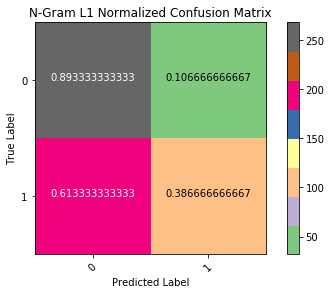

In [598]:
print("Naive Bayes Model with L1 norm")
calculate_model(GaussianNB(), train_post_l1_ng, train_label, test_post_l1_ng, test_label, dict,title="N-Gram L1 Normalized Confusion Matrix")

Naive Bayes Model with L2 norm
Accuracy: 0.635


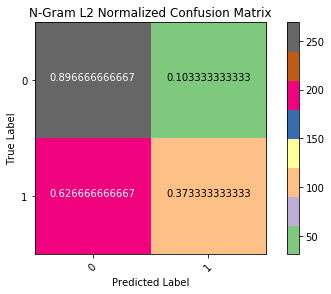

In [599]:
print("Naive Bayes Model with L2 norm")
calculate_model(GaussianNB(), train_post_l2_ng, train_label, test_post_l2_ng, test_label, dict,title="N-Gram L2 Normalized Confusion Matrix")

## h) PCA for bag of words model

In [602]:
# http://sebastianraschka.com/Articles/2014_pca_step_by_step.html
#Take the whole dataset consisting of dd-dimensional samples ignoring the class labels
def pca(dataset, n):
    #Compute the dd-dimensional mean vector 
    dataset -= dataset.mean(axis=0)
    
    #Compute the scatter matrix (alternatively, the covariance matrix) of the whole data set
    cov_mx = np.cov(dataset, rowvar=False)
    
    #Compute eigenvectors (ee1,ee2,...,eedee1,ee2,...,eed) and corresponding eigenvalues (λλ1,λλ2,...,λλdλλ1,λλ2,...,λλd)
    evals, evecs = np.linalg.eigh(cov_mx)
    
    #Sort the eigenvectors by decreasing eigenvalues and choose kk eigenvectors with the largest eigenvalues to form a d×kd×k dimensional matrix W
    i = np.argsort(evals)[::-1]
    
    #Use this d×kd×k eigenvector matrix to transform the samples onto the new subspace.
    evecs = evecs[:, i]
    evecs = evecs[:, :n]
    
    evals = evals[i]
    evals = evals[:n]
    
    return np.dot(evecs.T, dataset.T).T

#### Use data in e

In [610]:
train_pca_10_l2 = pca(train_post_l2, 10)
test_pca_10_l2 = pca(test_post_l2, 10)

train_pca_50_l2 = pca(train_post_l2, 50)
test_pca_50_l2 = pca(test_post_l2, 50)

train_pca_100_l2 = pca(train_post_l2, 100)
test_pca_100_l2 = pca(test_post_l2, 100)

#### Repeat in f

PCA 10 Regression Model with L2 norm
Accuracy: 0.5183333333333333


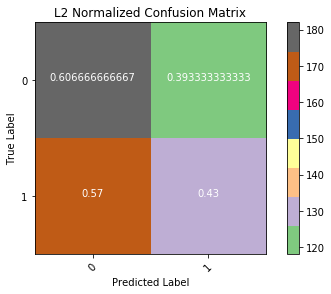

Weights:  [0 1 8 7 5 3 9 4 2 6]
20 Significant Words:
way
plug
excel
case
convert
unless
valu
go
us
good
PCA 10 Naive Bayes Model with L2 norm
Accuracy: 0.5733333333333334


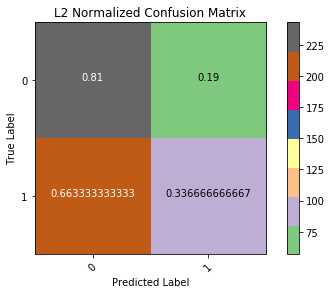

In [613]:
print("PCA 10 Regression Model with L2 norm")
calculate_model(LogisticRegression(), train_pca_10_l2, train_label, test_pca_10_l2, test_label, dict,title="L2 Normalized Confusion Matrix")

print("PCA 10 Naive Bayes Model with L2 norm")
calculate_model(GaussianNB(), train_pca_10_l2, train_label, test_pca_10_l2, test_label, dict,title="L2 Normalized Confusion Matrix")


PCA 50 Regression Model with L2 norm
Accuracy: 0.5


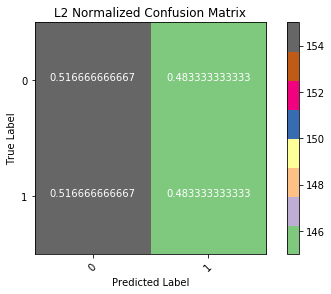

Weights:  [ 0 25  1 31 36 11  8  7 19 12 26 20 18 24 30 35 23 13 46  5]
20 Significant Words:
way
decent
plug
imagin
owner
jawbon
excel
case
problem
tie
volum
mic
major
right
contact
razr
line
charger
origin
convert
PCA 50 Naive Bayes Model with L2 norm
Accuracy: 0.5783333333333334


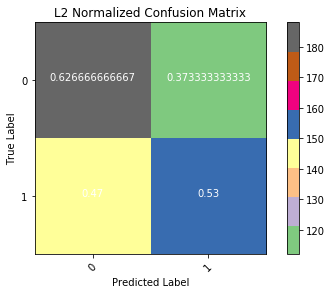

In [614]:
print("PCA 50 Regression Model with L2 norm")
calculate_model(LogisticRegression(), train_pca_50_l2, train_label, test_pca_50_l2, test_label, dict,title="L2 Normalized Confusion Matrix")

print("PCA 50 Naive Bayes Model with L2 norm")
calculate_model(GaussianNB(), train_pca_50_l2, train_label, test_pca_50_l2, test_label, dict,title="L2 Normalized Confusion Matrix")

PCA 100 Regression Model with L2 norm
Accuracy: 0.5283333333333333


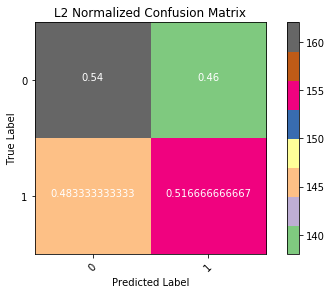

Weights:  [ 0 25  1 82 68 31 36 11  8 52  7 19 12 71 91 93 97 96 51 26]
20 Significant Words:
way
decent
plug
would
blue
imagin
owner
jawbon
excel
5
case
problem
tie
advis
use
fire
mislead
commerci
mere
volum
PCA 100 Naive Bayes Model with L2 norm
Accuracy: 0.5766666666666667


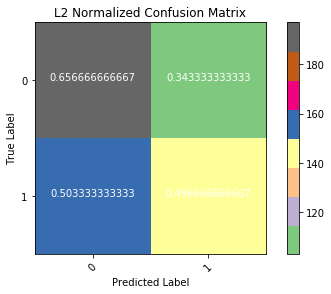

In [615]:
print("PCA 100 Regression Model with L2 norm")
calculate_model(LogisticRegression(), train_pca_100_l2, train_label, test_pca_100_l2, test_label, dict,title="L2 Normalized Confusion Matrix")

print("PCA 100 Naive Bayes Model with L2 norm")
calculate_model(GaussianNB(), train_pca_100_l2, train_label, test_pca_100_l2, test_label, dict,title="L2 Normalized Confusion Matrix")


#### Repeat in g

In [ ]:
train_post_pca_10_l2_ng = pca(train_post_l2_ng, 10)
test_post_pca_10_l2_ng = pca(test_post_l2_ng, 10)

In [617]:
train_post_pca_50_l2_ng = pca(train_post_l2_ng, 50)
test_post_pca_50_l2_ng = pca(test_post_l2_ng, 50)

In [618]:
train_post_pca_100_l2_ng = pca(train_post_l2_ng, 100)
test_post_pca_100_l2_ng = pca(test_post_l2_ng, 100)

PCA 10 Regression Model with L2 norm N-Gram
Accuracy: 0.49833333333333335


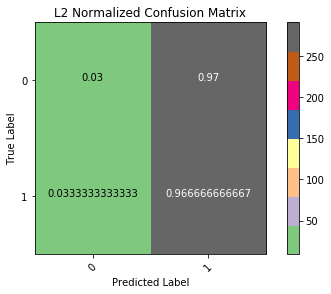

Weights:  [0 5 6 3 4 2 1 8 9 7]
20 Significant Words:
way
convert
good
unless
go
us
plug
excel
valu
case
PCA 10 Naive Bayes Model with L2 norm N-Gram
Accuracy: 0.545


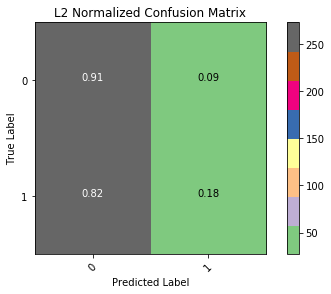

In [619]:
print("PCA 10 Regression Model with L2 norm N-Gram")
calculate_model(LogisticRegression(), train_post_pca_10_l2_ng, train_label, test_post_pca_10_l2_ng, test_label, dict,title="L2 Normalized Confusion Matrix")

print("PCA 10 Naive Bayes Model with L2 norm N-Gram")
calculate_model(GaussianNB(), train_post_pca_10_l2_ng, train_label, test_post_pca_10_l2_ng, test_label, dict,title="L2 Normalized Confusion Matrix")


PCA 50 Regression Model with L2 norm N-Gram
Accuracy: 0.4633333333333333


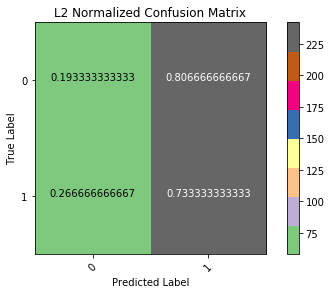

Weights:  [ 0  5 11 30  6 22 29 42  3 17 23 37 38 19 27 26  4 31 25 24]
20 Significant Words:
way
convert
jawbon
contact
good
get
hundr
time
unless
minut
line
must
needless
problem
sever
volum
go
imagin
decent
right
PCA 50 Naive Bayes Model with L2 norm N-Gram
Accuracy: 0.5433333333333333


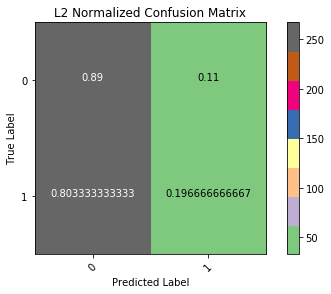

In [620]:
print("PCA 50 Regression Model with L2 norm N-Gram")
calculate_model(LogisticRegression(), train_post_pca_50_l2_ng, train_label, test_post_pca_50_l2_ng, test_label, dict,title="L2 Normalized Confusion Matrix")

print("PCA 50 Naive Bayes Model with L2 norm N-Gram")
calculate_model(GaussianNB(), train_post_pca_50_l2_ng, train_label, test_post_pca_50_l2_ng, test_label, dict,title="L2 Normalized Confusion Matrix")


PCA 100 Regression Model with L2 norm N-Gram
Accuracy: 0.525


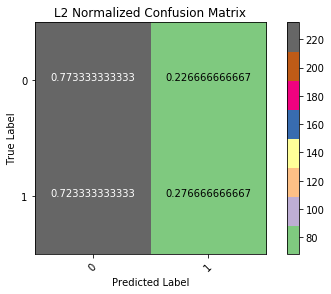

Weights:  [ 0  5 11 30  6 22 29 42  3 17 23 66 37 38 19 84 27 57 26 92]
20 Significant Words:
way
convert
jawbon
contact
good
get
hundr
time
unless
minut
line
highli
must
needless
problem
motorola
sever
static
volum
kindl
PCA 100 Naive Bayes Model with L2 norm N-Gram
Accuracy: 0.5466666666666666


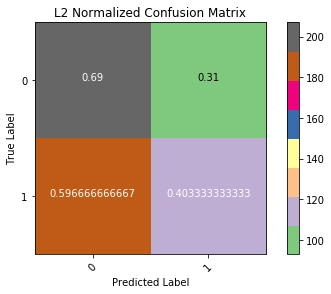

In [ ]:
print("PCA 100 Regression Model with L2 norm N-Gram")
calculate_model(LogisticRegression(), train_post_pca_100_l2_ng, train_label, test_post_pca_100_l2_ng, test_label, dict,title="L2 Normalized Confusion Matrix")

print("PCA 100 Naive Bayes Model with L2 norm N-Gram")
calculate_model(GaussianNB(), train_post_pca_100_l2_ng, train_label, test_post_pca_100_l2_ng, test_label, dict,title="L2 Normalized Confusion Matrix")
